<a href="https://colab.research.google.com/github/rrxloyeon/BASIC_text_mining/blob/main/sentiment_analysis_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 준비 : NLTK 영화 리뷰 데이터

In [1]:
import nltk
nltk.download('movie_reviews')

from nltk.corpus import movie_reviews
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
fileids = movie_reviews.fileids()
reviews = [movie_reviews.raw(fileid) for fileid in fileids]
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

## 데이터 정보

In [3]:
print('#review count:', len(movie_reviews.fileids()))
print('#samples of file ids:', movie_reviews.fileids()[:10])
print('#categories of reviews:', movie_reviews.categories())
print('#num of "neg" reviews:', len(movie_reviews.fileids(categories='neg')))
print('#num of "pos" reviews:', len(movie_reviews.fileids(categories='pos')))
fileid = movie_reviews.fileids()[0]
print('#id of the first review:', fileid)
print('#part of the first review:', movie_reviews.raw(fileid)[:500])
print('#sentiment of the first review:', movie_reviews.categories(fileid))

#review count: 2000
#samples of file ids: ['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt']
#categories of reviews: ['neg', 'pos']
#num of "neg" reviews: 1000
#num of "pos" reviews: 1000
#id of the first review: neg/cv000_29416.txt
#part of the first review: plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt
#sentiment of the first review: ['neg']


# 감성 사전을 이용한 감성분석

## TextBlob

In [4]:
!pip install -U textblob
!python -m textblob.download_corpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [5]:
from textblob import TextBlob

result = TextBlob(reviews[0])
print(result.sentiment)

Sentiment(polarity=0.06479782948532947, subjectivity=0.5188408350908352)


In [6]:
def sentiment_TextBlob(docs):
  results = []
  for doc in docs:
    testimonial = TextBlob(doc)
    if testimonial.sentiment.polarity > 0:
      results.append('pos')
    else:
      results.append('neg')
  return results

In [7]:
%time print('#TextBlob accuracy:', accuracy_score(categories, sentiment_TextBlob(reviews)))

#TextBlob accuracy: 0.6
CPU times: user 9.94 s, sys: 43.6 ms, total: 9.98 s
Wall time: 10.8 s


## AFINN

In [8]:
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from afinn import Afinn
def sentiment_Afinn(docs):
  afn = Afinn(emoticons=True)
  results = []

  for doc in docs:
    if afn.score(doc) > 0:
      results.append('pos')
    else:
      results.append('neg')
  return results

In [10]:
%time print('#AFINN accuracy:', accuracy_score(categories, sentiment_Afinn(reviews)))

#AFINN accuracy: 0.664
CPU times: user 48.5 s, sys: 168 ms, total: 48.7 s
Wall time: 54.5 s


##VADER

In [11]:
import nltk
nltk.download('vader_lexicon')

# !pip install vaderSentiment

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentiment_vader(docs):
  analyser = SentimentIntensityAnalyzer()
  results = []

  for doc in docs:
    score = analyser.polarity_scores(doc)
    if score['compound'] > 0:
      results.append('pos')
    else:
      results.append('neg')

  return results

In [13]:
%time print('#Vader accuracy:', accuracy_score(categories, sentiment_vader(reviews)))

#Vader accuracy: 0.635
CPU times: user 24.5 s, sys: 194 ms, total: 24.7 s
Wall time: 30.3 s


# 오답 분석

In [14]:
import matplotlib.pyplot as plt

- TextBlob (-1.0, 1.0)

In [15]:
# TextBlob
result_polarity = []
result_subjectivity = []
incorrect_polarity = []
incorrect_subjectivity = []
incorrect_idx = []
for idx, pack in enumerate(zip(categories, reviews)):
  true, doc = pack
  test = TextBlob(doc)
  pred = test.sentiment.polarity
  sub = test.sentiment.subjectivity
  result_polarity.append(pred)
  result_subjectivity.append(sub)
  if pred > 0 and true == 'neg':
    incorrect_idx.append(idx)
    incorrect_polarity.append(pred)
    incorrect_subjectivity.append(sub)
  elif pred <= 0 and true == 'pos':
    incorrect_idx.append(idx)
    incorrect_polarity.append(pred)
    incorrect_subjectivity.append(sub)

#number of total data: 2000
#number of incorrect:800 (40.0%)
#average of incorrect polarities: 0.07421264142459869
#average of incorrect subjectivities: 0.5099037431685902
#sample incorrect doc: plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with

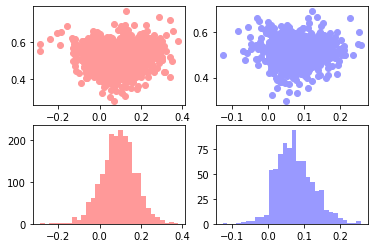

In [16]:
print('#number of total data:', len(result_polarity))
print(f'#number of incorrect:{len(incorrect_polarity)} ({len(incorrect_polarity)/len(result_polarity)*100}%)')
print("#average of incorrect polarities:", sum(incorrect_polarity)/len(incorrect_polarity))
print("#average of incorrect subjectivities:", sum(incorrect_subjectivity)/len(incorrect_subjectivity))
print("#sample incorrect doc:", reviews[incorrect_idx[0]])

# total plot
plt.subplot(221)
plt.scatter(result_polarity, result_subjectivity, c='#FF9999')

plt.subplot(223)
plt.hist(result_polarity, bins=30, color='#FF9999')

plt.subplot(222)
plt.scatter(incorrect_polarity, incorrect_subjectivity, c='#9999FF')

plt.subplot(224)
plt.hist(incorrect_polarity, bins=30, color='#9999FF')

plt.show()

- AFINN (-5, 5)

In [17]:
# AFINN
afn = Afinn(emoticons=True)
incorrect_idx2 = []
result_afinn = []
incorrect_afinn = []
for idx, pack in enumerate(zip(categories, reviews)):
  true, doc = pack
  pred = afn.score(doc)
  result_afinn.append(pred)
  if pred > 0 and true == 'neg':
    incorrect_idx2.append(idx)
    incorrect_afinn.append(pred)
  elif pred <= 0 and true == 'pos':
    incorrect_idx2.append(idx)
    incorrect_afinn.append(pred)

#number of total data: 2000
#number of incorrect:672 (33.6%)
#average of incorrect: 8.428571428571429
182.0
-111.0
#sample incorrect doc: the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with 

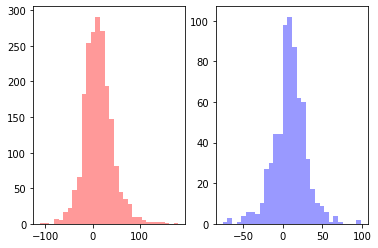

In [18]:
print('#number of total data:', len(result_afinn))
print(f'#number of incorrect:{len(incorrect_afinn)} ({len(incorrect_afinn)/len(result_afinn)*100}%)')
print("#average of incorrect:", sum(incorrect_afinn)/len(incorrect_afinn))
print(max(result_afinn))
print(min(result_afinn))
print("#sample incorrect doc:", reviews[incorrect_idx2[0]])

# total plot
plt.subplot(121)
plt.hist(result_afinn, bins=30, color='#FF9999')

plt.subplot(122)
plt.hist(incorrect_afinn, bins=30, color='#9999FF')

plt.show()

In [19]:
# vader
vader = SentimentIntensityAnalyzer()
result_vader = []
incorrect_vader = []
incorrect_idx3 = []
for idx, pack in enumerate(zip(categories, reviews)):
  true, doc = pack
  pred = vader.polarity_scores(doc)['compound']
  result_vader.append(pred)
  if pred > 0 and true == 'neg':
    incorrect_idx3.append(idx)
    incorrect_vader.append(pred)
  elif pred <= 0 and true == 'pos':
    incorrect_idx3.append(idx)
    incorrect_vader.append(pred)

#number of total data: 2000
#number of incorrect:730 (36.5%)
#average of incorrect: 0.4803921917808211
0.9999
-0.9997
#sample incorrect doc: plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's sim

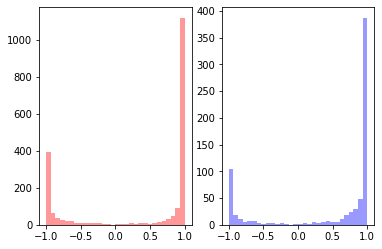

In [20]:
print('#number of total data:', len(result_vader))
print(f'#number of incorrect:{len(incorrect_vader)} ({len(incorrect_vader)/len(result_vader)*100}%)')
print("#average of incorrect:", sum(incorrect_vader)/len(incorrect_vader))
print(max(result_vader))
print(min(result_vader))
print("#sample incorrect doc:", reviews[incorrect_idx3[0]])

# total plot
plt.subplot(121)
plt.hist(result_vader, bins=30, color='#FF9999')

plt.subplot(122)
plt.hist(incorrect_vader, bins=30, color='#9999FF')

plt.show()

- 오답 처리된 index 비교

In [36]:
'''
incorrect_idx : TextBlob
incorrect_idx2 : AFINN
incorrect_idx3 : Vader
'''
cnt = []
for i in range(len(reviews)):
  temp = 0
  if i in incorrect_idx: temp += 1
  if i in incorrect_idx2: temp += 1
  if i in incorrect_idx3: temp += 1
  cnt.append(temp)

print('#number of all correct:', cnt.count(0))
print('#number of 1 incorrect:', cnt.count(1))
print('#number of 2 incorrect:', cnt.count(2))
print('#number of 3 incorrect:', cnt.count(3))

#number of all correct: 926
#number of 1 incorrect: 354
#number of 2 incorrect: 312
#number of 3 incorrect: 408


# 앙상블!

## 직접 구현하기
- TextBlob, AFINN, Vader를 사용하여 voting 방식으로 앙상블한 결과를 출력해본다!
- **soft voting** : 추정값의 평균을 낸 다음 분류
  - 세가지 방법이 서로 결과값의 범위가 다르기 때문에 normalized 해줘야 함
- **hard voting** : 추정값으로 추론을 한 다음 과반수를 차지한 클래스로 분류

In [21]:
def absone_norm(value, absrange):
  # -1.0 ~ 1.0 으로 normalize 하는 함수 
  if absrange == 0:
    raise Exception("can not divided by 0, change value of 'absrange'")
  
  return value/absrange

In [31]:
import numpy as np

def soft_voting(docs):
  result = []
  afn = Afinn(emoticons=True)
  vader = SentimentIntensityAnalyzer()

  for doc in docs:
    analyzer = []
    analyzer.append(TextBlob(doc).sentiment.polarity)
    analyzer.append(absone_norm(afn.score(doc), 182))
    # analyzer.append(vader.polarity_scores(doc)['compound'])

    if sum(analyzer)/len(analyzer) > 0:
      result.append('pos')
    else:
      result.append('neg')

  return result

In [32]:
def hard_voting(docs):
  result = []
  analyzer = []
  analyzer.append(sentiment_TextBlob(docs))
  analyzer.append(sentiment_Afinn(docs))
  # analyzer.append(sentiment_vader(docs))

  for t in zip(*analyzer):
    npos = t.count('pos')
    nneg = t.count('neg')
    if npos+nneg != len(analyzer):
      raise Exception('check number of npos and nneg')
    
    if npos > nneg:
      result.append('pos')
    else:
      result.append('neg')
  
  return result

In [33]:
%time print('#soft voting accuracy:', accuracy_score(categories, soft_voting(reviews)))
%time print('#hard voting accuracy:', accuracy_score(categories, hard_voting(reviews)))

#soft voting accuracy: 0.639
CPU times: user 56.6 s, sys: 195 ms, total: 56.8 s
Wall time: 58.6 s
#hard voting accuracy: 0.6755
CPU times: user 59.1 s, sys: 218 ms, total: 59.3 s
Wall time: 1min 7s


In [25]:
from scipy.special import softmax
weight = softmax([0.6, 0.664, 0.635]) # TextBlob, AFINN, Vader
print(weight)

[0.32240258 0.34371094 0.33388647]


In [34]:
def weighted_soft_voting(docs):
  global weight
  result = []
  afn = Afinn(emoticons=True)
  vader = SentimentIntensityAnalyzer()

  for doc in docs:
    analyzer = []
    analyzer.append(TextBlob(doc).sentiment.polarity)
    analyzer.append(absone_norm(afn.score(doc), 5))
    # analyzer.append(vader.polarity_scores(doc)['compound'])

    if sum(np.array(analyzer) * np.array(weight[:2]))/len(analyzer) > 0:
      result.append('pos')
    else:
      result.append('neg')

  return result

In [35]:
%time print('#weighted soft voting accuracy:', accuracy_score(categories, weighted_soft_voting(reviews)))

#weighted soft voting accuracy: 0.6615
CPU times: user 1min, sys: 230 ms, total: 1min
Wall time: 1min 6s


# 머신러닝 기반의 감성 분석

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews, categories, test_size=0.2, random_state=7)

print('Train set count:', len(X_train))
print('test set count:', len(X_test))

Train set count: 1600
test set count: 400


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train) 
print('#Train set dimension:', X_train_tfidf.shape)

X_test_tfidf = tfidf.transform(X_test)
print('#Test set dimension:', X_test_tfidf.shape)

NB_clf = MultinomialNB(alpha=0.01)
%time NB_clf.fit(X_train_tfidf, y_train)
print('#Train set score: {:.3f}'.format(NB_clf.score(X_train_tfidf, y_train)))
print('#Test set score: {:.3f}'.format(NB_clf.score(X_test_tfidf, y_test)))

#Train set dimension: (1600, 36189)
#Test set dimension: (400, 36189)
CPU times: user 11.6 ms, sys: 4 µs, total: 11.6 ms
Wall time: 10.9 ms
#Train set score: 0.998
#Test set score: 0.797
